# Lensing Theory Calculations

Examples of using `randomfield.lensing` functions to perform theoretical calculations related to weak lensing.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import randomfield
print randomfield.__version__

0.2.dev258


/Users/david/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from randomfield.lensing import *
from randomfield.cosmotools import calculate_power
from randomfield.cosmotools import get_growth_function

Define some cosmologies to use for testing.  We use the fiducial models from Table 1 of Weinberg 2012 with $\Omega_k = 0$ (flat) and $\pm 0.01$ (open/closed), which all have essentially the same CMB power spectra.

In [4]:
from astropy.cosmology import LambdaCDM
flat_model = LambdaCDM(Ob0=0.045, Om0=0.222+0.045, Ode0=0.733, H0=71.0)
open_model = LambdaCDM(Ob0=0.038, Om0=0.186+0.038, Ode0=0.766, H0=77.6)
closed_model = LambdaCDM(Ob0=0.052, Om0=0.256+0.052, Ode0=0.702, H0=66.1)
assert np.allclose((flat_model.Ok0, open_model.Ok0, closed_model.Ok0), (0.0, +0.01, -0.01), atol=1e-4)

Define the redshift grid to use.  The same grid is used for lensing masses as sources, so you should usually specify a fine grid even if you only need results for a few source redshifts.  Redshifts do not need to be equally spaced.

In [5]:
z = np.linspace(0.0, 2.5, 251)

Calculate the lensing weight function $W(z, z_{src})$ for each cosmology:

In [6]:
flat_weights = calculate_lensing_weights(flat_model, z, scaled_by_h=True)
open_weights = calculate_lensing_weights(open_model, z, scaled_by_h=True)
closed_weights = calculate_lensing_weights(closed_model, z, scaled_by_h=True)

Plot the weight function for several source redshifts.  Note that:

- Weights are broadly peaked with a maximum value at $z_{lens} \simeq z_{src}/2$.
- Weights are larger for larger source redshifts since more distance source experience more lensing.
- Weights increase (decrease) slightly in a closed (open) universe.

The different line styles show weights for a flat (solid), open (dashed), or closed (dotted) universe.

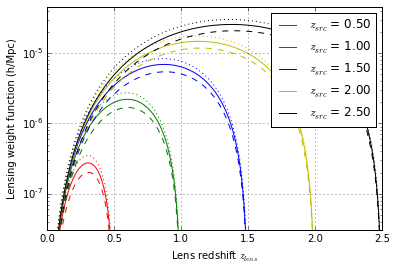

In [7]:
def plot_weights():
    colors = ('r', 'g', 'b', 'y', 'k')
    for j,iz in enumerate(range(50, 251, 50)):
        plt.plot(z, flat_weights[iz], color=colors[j], label='$z_{src}$ = %.2f' % z[iz])
        plt.plot(z, open_weights[iz], color=colors[j], ls='--')
        plt.plot(z, closed_weights[iz], color=colors[j], ls=':')
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlabel('Lens redshift $z_{lens}$')
    plt.ylabel('Lensing weight function (h/Mpc)')
    plt.xlim(0,z[-1])
    y_max = max(np.max(flat_weights), np.max(open_weights), np.max(closed_weights))
    plt.ylim(1e-3 * y_max, 1.5 * y_max)
    plt.grid()
    plt.show()

plot_weights()

Define the grid of 2D wavenumbers $\ell$ to use.  Use log-spaced values covering the mostly linear regime. We do not need very fine spacing here since the shear power varies slowly with $\ell$.

In [8]:
ell = np.logspace(1., 3., 21)

Tabulate the distance functions for each cosmology in Mpc/h:

In [9]:
import astropy.units as u
flat_DC = flat_model.comoving_distance(z).to(u.Mpc).value * flat_model.h
open_DC = open_model.comoving_distance(z).to(u.Mpc).value * flat_model.h
closed_DC = closed_model.comoving_distance(z).to(u.Mpc).value * flat_model.h
flat_DA = flat_model.comoving_transverse_distance(z).to(u.Mpc).value * flat_model.h
open_DA = open_model.comoving_transverse_distance(z).to(u.Mpc).value * open_model.h
closed_DA = closed_model.comoving_transverse_distance(z).to(u.Mpc).value * closed_model.h

Compare the distance functions. Line styles are solid for $D_C(z)$ and dashed for $D_A(z)$.

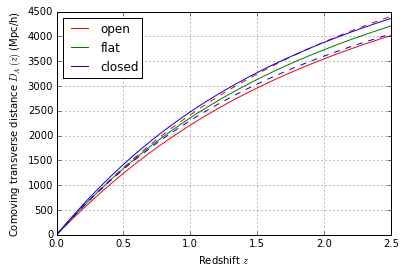

In [10]:
plt.plot(z, open_DC, 'r-', label='open')
plt.plot(z, open_DA, 'r--')
plt.plot(z, flat_DC, 'g-', label='flat')
plt.plot(z, closed_DC, 'b-',label='closed')
plt.plot(z, closed_DA, 'b--')
plt.grid()
plt.xlabel('Redshift $z$')
plt.ylabel('Comoving transverse distance $D_A(z)$ (Mpc/h)')
plt.legend(loc='upper left')
plt.show()

Define the range of 3D wavenumbers $k = \ell/D_A$ needed to cover the calculation of the shear power. We have to set a minimum value of $D_A$ to use in order to establish a finite upper limit on $k$. Units are Mpc/h.

In [11]:
izmin = 10
print 'Shear power calculation truncated at z >= %.2f' % z[izmin]

DA_min = min(flat_DA[izmin], open_DA[izmin], closed_DA[izmin])
DA_max = max(flat_DA[-1], open_DA[-1], closed_DA[-1])
print 'Using %.1f Mpc/h < DA < %.1f Mpc/h' % (DA_min, DA_max)

k_min, k_max = ell[0] / DA_max, ell[-1] / DA_min
print 'Using %.4f h/Mpc <= k <= %.4f h/Mpc' % (k_min, k_max)

Shear power calculation truncated at z >= 0.10
Using 292.9 Mpc/h < DA < 4408.6 Mpc/h
Using 0.0023 h/Mpc <= k <= 3.4144 h/Mpc


Calculate the matter power at z=0 for each of the fiducial cosmologies using the optional CLASS package. Units are h/Mpc for $k$ and (Mpc/h)**3 for $P(k)$.

In [12]:
flat_power = calculate_power(flat_model, k_min=k_min, k_max=k_max, scaled_by_h=True)
open_power = calculate_power(open_model, k_min=k_min, k_max=k_max, scaled_by_h=True)
closed_power = calculate_power(closed_model, k_min=k_min, k_max=k_max, scaled_by_h=True)

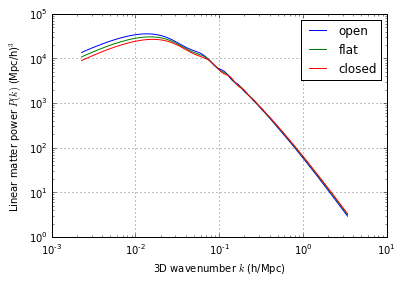

In [13]:
plt.plot(open_power['k'], open_power['Pk'], label='open')
plt.plot(flat_power['k'], flat_power['Pk'], label='flat')
plt.plot(closed_power['k'], closed_power['Pk'], label='closed')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('3D wavenumber $k$ (h/Mpc)')
plt.ylabel('Linear matter power $P(k)$ (Mpc/h)$^3$')
plt.grid()
plt.show()

Calculate the growth function for each cosmology:

In [14]:
flat_growth = get_growth_function(flat_model, z)
open_growth = get_growth_function(open_model, z)
closed_growth = get_growth_function(closed_model, z)

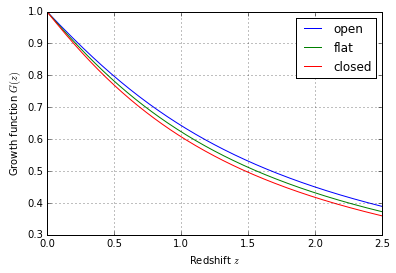

In [15]:
plt.plot(z, open_growth, label='open')
plt.plot(z, flat_growth, label='flat')
plt.plot(z, closed_growth, label='closed')
plt.legend(loc='upper right')
plt.xlabel('Redshift $z$')
plt.ylabel('Growth function $G(z)$')
plt.grid()
plt.show()

Calculate the 3D variance contributions $V(\ell, D_A)$ for each cosmology, with $D_A > D_A(z_{min})$.

In [16]:
flat_variances = tabulate_3D_variances(ell, flat_DA[izmin:], flat_growth[izmin:], flat_power)
open_variances = tabulate_3D_variances(ell, open_DA[izmin:], open_growth[izmin:], open_power)
closed_variances = tabulate_3D_variances(ell, closed_DA[izmin:], closed_growth[izmin:], closed_power)

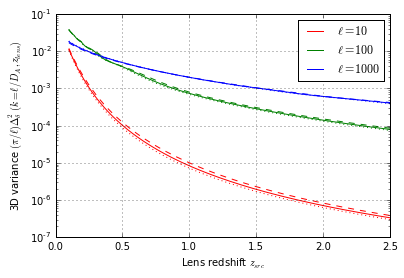

In [17]:
colors = ('r', 'g', 'b')
for j,iell in enumerate(range(0, 21, 10)):
    plt.plot(z[izmin:], flat_variances[iell], color=colors[j], label='$\ell = %.0f$' % ell[iell])
    plt.plot(z[izmin:], open_variances[iell], color=colors[j], ls='--')
    plt.plot(z[izmin:], closed_variances[iell], color=colors[j], ls=':')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Lens redshift $z_{src}$')
plt.ylabel('3D variance $(\pi/\ell) \Delta^2_{\delta}(k = \ell/D_A, z_{lens})$')
plt.grid()
plt.show()

Calculate the shear power $\Delta^2_{EE}(z_{src}, \ell)$ as a function of source position and 2D wavenumber.

In [18]:
flat_shear_power = calculate_shear_power(flat_DC[izmin:], flat_weights[izmin:,izmin:], flat_variances)
open_shear_power = calculate_shear_power(open_DC[izmin:], open_weights[izmin:,izmin:], open_variances)
closed_shear_power = calculate_shear_power(closed_DC[izmin:], closed_weights[izmin:,izmin:], closed_variances)

Compare the calculated shear powers. Line styles are solid for the flat universe, dashed for the open universe, and dotted for the closed universe.

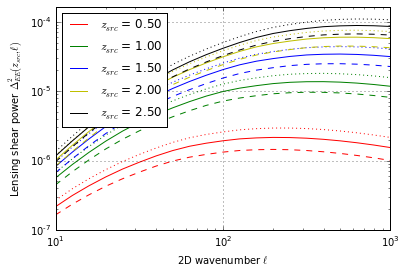

In [19]:
def plot_shear_power():
    colors = ('r', 'g', 'b', 'y', 'k')
    for j,iz in enumerate(range(50, 251, 50)):
        plt.plot(ell, flat_shear_power[iz - izmin], color=colors[j], label='$z_{src}$ = %.2f' % z[iz])
        plt.plot(ell, open_shear_power[iz - izmin], color=colors[j], ls='--')
        plt.plot(ell, closed_shear_power[iz - izmin], color=colors[j], ls=':')
    plt.legend(loc='upper left')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('2D wavenumber $\ell$')
    plt.ylabel('Lensing shear power $\Delta^2_{EE}(z_{src}, \ell)$')
    plt.xlim(ell[0],ell[-1])
    y_max = max(np.max(flat_shear_power), np.max(open_shear_power), np.max(closed_shear_power))
    plt.ylim(None, 1.5 * y_max)
    plt.grid()
    #plt.savefig('shearpower.png')
    plt.show()

plot_shear_power()